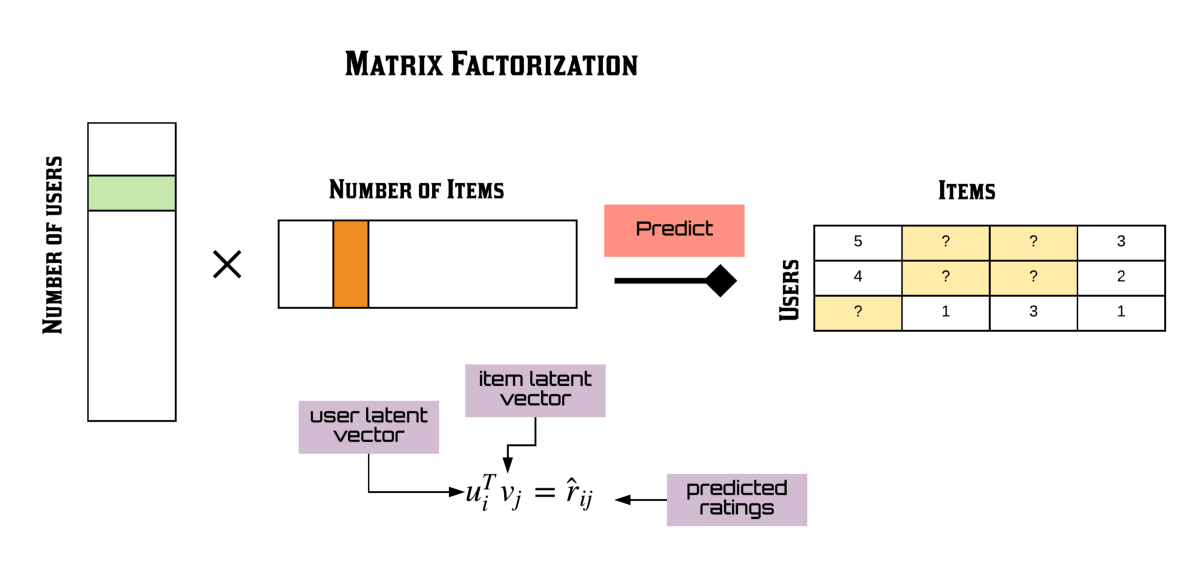

Matrix factorization is a class of collaborative filtering algorithms used in recommender systems. Basically, matrix factorization characterizes both items and users by vectors of factors inferred from item rating patterns.

**Basic Idea**  

First of all, our main purpose is to find out how many points our customers who have not read a movie, book, or item can give these items. The intuition behind using matrix factorization to solve this problem is that there should be some latent features that determine how a user rates an item. For example, two users would give high ratings to a certain movie if they both like the actors/actresses of the movie, or if the movie is an action movie, which is a genre preferred by both users. Hence, if we can discover these latent features, we should be able to predict a rating with respect to a certain user and a certain item, because the features associated with the user should match with the features associated with the item.


In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)
from surprise import Reader, SVD, SVDpp, Dataset, accuracy
from surprise.model_selection import GridSearchCV, train_test_split, cross_validate

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('df_recipe.csv', index_col=0)

In [3]:
recipe_ids = df.recipe_id.value_counts()[:1000].index.tolist()
user_ids = df.user_id.value_counts()[:1000].index.tolist()

In [4]:
sample_df = df[df.recipe_id.isin(recipe_ids) & df.user_id.isin(user_ids)]

In [5]:
sample_df.head()

,name,recipe_id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,n_ingredients,user_id,date,rating,review,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),year
164,how i got my family to eat spinach spinach ca...,25775,50,37305,2002-04-22,"['60-minutes-or-less', 'time-to-make', 'course...",5.0,preheat oven to 350 degrees place spinach in s...,"if spinach scares you, this is one recipe that...",frozen chopped spinach egg salt black pepper o...,8,29956,2002-04-23,3.0,"It was alright, but won't be rushing out to ma...",166.1,16.0,6.0,32.0,19.0,26.0,3.0,2002
179,how i got my family to eat spinach spinach ca...,25775,50,37305,2002-04-22,"['60-minutes-or-less', 'time-to-make', 'course...",5.0,preheat oven to 350 degrees place spinach in s...,"if spinach scares you, this is one recipe that...",frozen chopped spinach egg salt black pepper o...,8,22015,2005-08-24,4.0,Very cheesy. I love spinach so I'm willing to...,166.1,16.0,6.0,32.0,19.0,26.0,3.0,2005
180,how i got my family to eat spinach spinach ca...,25775,50,37305,2002-04-22,"['60-minutes-or-less', 'time-to-make', 'course...",5.0,preheat oven to 350 degrees place spinach in s...,"if spinach scares you, this is one recipe that...",frozen chopped spinach egg salt black pepper o...,8,130219,2005-10-01,5.0,Karen this is the way I will fix my spinach fr...,166.1,16.0,6.0,32.0,19.0,26.0,3.0,2005
188,how i got my family to eat spinach spinach ca...,25775,50,37305,2002-04-22,"['60-minutes-or-less', 'time-to-make', 'course...",5.0,preheat oven to 350 degrees place spinach in s...,"if spinach scares you, this is one recipe that...",frozen chopped spinach egg salt black pepper o...,8,173579,2006-06-23,4.0,We thought this was just ok. Thanks for posting.,166.1,16.0,6.0,32.0,19.0,26.0,3.0,2006
189,how i got my family to eat spinach spinach ca...,25775,50,37305,2002-04-22,"['60-minutes-or-less', 'time-to-make', 'course...",5.0,preheat oven to 350 degrees place spinach in s...,"if spinach scares you, this is one recipe that...",frozen chopped spinach egg salt black pepper o...,8,183964,2006-07-08,5.0,We are already spinach lovers so this was exce...,166.1,16.0,6.0,32.0,19.0,26.0,3.0,2006


In [6]:
user_food_df = sample_df.pivot_table(index=["user_id"],
                                     columns=["recipe_id"],
                                     values="rating")

**All the information we have about the existing ratings can be represented in a matrix.**

In [7]:
user_food_df

recipe_id   607     749     822     860     1005    1356    1985    2496    2708    2886    3180    3595    3603    4075    4178    4332    4417    4573    4627    4861    4957    5031    5170    5247    5478    8060    8424    8432    8554    8579    8595    8596    8619    8650    8701    8739    8782    8794    8969    8972    9054    9240    9272    9370    9494    9782    9836    9954    10125   10481   10744   10840   11028   11107   11217   11266   11345   11642   11763   11808   11919   11923   12134   12199   12316   12360   12365   12522   12591   12619   12832   12877   13214   13269   13285   13307   13320   13546   13619   13707   13745   13949   13982   14106   14187   14325   14357   14499   14569   14684   14756   14906   14911   14979   15072   15242   15286   15411   15489   15846   15865   16213   16273   16371   16399   16531   16687   16705   16884   16887   16902   17126   17181   17186   17227   17251   17394   17566   17586   17722   17962   17977   17987   18185   18387   18458   18693   18816   18872   18888   18914   18947   19023   19253   19424   19653   19678   19710   19724   20048   20099   20155   20184   20287   20431   20616   20624   20643   21304   21320   21363   21597   21761   21768   21882   22164   22169   22176   22274   22539   22782   23108   23232   23480   23687   23939   24019   24088   24139   24306   24476   24576   24618   24672   24712   24952   25094   25625   25723   25730   25745   25757   25775   25806   25885   25999   26110   26111   26168   26205   26210   26217   26230   26257   26306   26337   26339   26370   26420   26451   26476   26526   26557   26766   26773   26820   26845   26849   26932   26947   27144   27208   27210   27221   27520   27733   27931   27968   28011   28026   28091   28148   28165   28377   28603   28648   28662   28667   28758   28768   28927   28943   29002   29100   29155   29175   29210   29251   29301   29329   29413   29493   29544   29598   29679   29704   29884   29935   30018   30081   30165   30358   30366   30484   30745   30812   30946   30951   30965   31078   31128   31167   31235   31314   31342   31371   31516   31562   31607   31717   31750   31799   31804   31811   32042   32142   32147   32204   32295   32503   32522   32607   32614   32618   32731   32734   32756   32833   32844   32880   32973   33105   33170   33489   33645   33665   33671   33869   33914   33919   33921   34011   34335   34382   34499   34688   34753   34881   35185   35393   35775   35805   35889   35988   36784   36797   36847   36970   36984   37139   37336   37374   37413   37437   37548   37625   37638   38041   38088   38137   38298   38432   38641   38746   38846   38953   38966   39087   39369   39618   39900   40106   40497   40983   41156   41384   41541   41701   41705   41992   42071   42094   42169   42292   42564   42603   42780   42976   43023   43072   43509   43850   43908   44133   44232   44278   44487   44833   45005   45006   45069   45609   45940   46072   46262   46267   46461   46501   46739   46780   46798   46877   46922   47195   47326   47391   47515   48356   48401   48532   48635   48760   48957   49172   49181   49200   49230   49387   49534   49591   49737   50022   50144   50338   50342   50385   50453   50684   50719   50722   50732   50767   50772   50979   51104   51140   51199   51209   51537   51550   51997   52035   52064   52104   52206   52253   52272   52366   52488   52500   52757   52892   52999   53081   53198   53301   53508   53876   53878   53914   54257   54259   54351   54677   54715   55514   55673   55768   55796   55936   56103   56366   56453   56652   56694   56846   57062   57130   57299   57505   57591   57629   57679   57772   57872   57919   58428   58823   58976   59224   59289   59336   59363   59469   59635   59636   59772   59829   59965   60085   60235   60350   60382   60560   61610   62058   62480   63017   63071   63138   63244   63446   63501   63689   63712   63786   63828   63860   6401

**Here we represented users and recipes in a matrix. Then we apply the SVD.**

In [8]:
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(df[['user_id',
                                'recipe_id',
                                'rating']], reader)

In [9]:
trainset, testset = train_test_split(data, test_size=.25, random_state=99)
svd_model = SVD()
svd_model.fit(trainset)

**First, we train our model and then measure our success on a test set that the model has never seen.**

In [10]:
predictions = svd_model.test(testset)

In [11]:
predictions[:10]

[Prediction(uid=2460740, iid=262830, r_ui=5.0, est=4.232022891887652, details={'was_impossible': False}),
 Prediction(uid=11811, iid=89204, r_ui=4.0, est=3.9209439419431065, details={'was_impossible': False}),
 Prediction(uid=62085, iid=46656, r_ui=5.0, est=4.831470390960653, details={'was_impossible': False}),
 Prediction(uid=653438, iid=458530, r_ui=5.0, est=4.8838992998566155, details={'was_impossible': False}),
 Prediction(uid=42290, iid=42976, r_ui=5.0, est=4.821940533775491, details={'was_impossible': False}),
 Prediction(uid=852529, iid=10744, r_ui=5.0, est=3.7714887166999564, details={'was_impossible': False}),
 Prediction(uid=2000895313, iid=312361, r_ui=5.0, est=4.118424167210924, details={'was_impossible': False}),
 Prediction(uid=1355867, iid=14410, r_ui=5.0, est=4.648061103499845, details={'was_impossible': False}),
 Prediction(uid=1531249, iid=126584, r_ui=5.0, est=4.723591448223704, details={'was_impossible': False}),
 Prediction(uid=945248, iid=112443, r_ui=5.0, est=5, 

**uid : userid  
  iid: item id  
  r_ui : rating associated with user i, item i (actual rating)  
  est = prediction**

In [12]:
accuracy.rmse(predictions)

RMSE: 1.2217


1.2216839231401593

In [13]:
svd_model.predict(uid=56181, iid=67422, verbose=True)

user: 56181      item: 67422      r_ui = None   est = 4.86   {'was_impossible': False}


Prediction(uid=56181, iid=67422, r_ui=None, est=4.858196365286994, details={'was_impossible': False})

In [14]:
df.loc[(df['user_id'] == 56181) & (df['recipe_id'] == 67422), 'rating']

196472    5.0
Name: rating, dtype: float64

**predicted and actual rating of a particular user and item relationship**

In [15]:
param_grid = {'n_epochs': [5, 10, 20],
              'lr_all': [0.002, 0.005, 0.007, 0.01]}


gs = GridSearchCV(SVD,
                  param_grid,
                  measures=['rmse', 'mae'],
                  cv=3,
                  n_jobs=-1,
                  joblib_verbose=True)

gs.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  6.1min finished


In [16]:
gs.best_score['rmse']

1.2205651816852636

**As a result of hyperparameter optimization, model success seems to have increased slightly.**

In [17]:
gs.best_params['rmse']

{'n_epochs': 10, 'lr_all': 0.007}

In [18]:
svd_model = SVD(**gs.best_params['rmse'])

In [19]:
data = data.build_full_trainset()
svd_model.fit(data)

In [20]:
svd_model.predict(uid=852529, iid=10744, verbose=True)

user: 852529     item: 10744      r_ui = None   est = 3.98   {'was_impossible': False}


Prediction(uid=852529, iid=10744, r_ui=None, est=3.981192993204688, details={'was_impossible': False})

In [21]:
df.loc[(df['user_id'] == 852529) & (df['recipe_id'] == 10744), 'rating']

353696    5.0
Name: rating, dtype: float64

**Our prediction for this user before the hyperparameter optimization was 3.77. Then we got closer to the actual rating.**

### Conclusion

**As a result, we make a rating prediction based on user latent factors and item latent factors.**

**To give an example of our study, these latent factors can be factors such as the bitterness of the food, its presentation, the nutritional value it contains, the person who submitted the recipe, and the taste of the person who commented**